In [355]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import cvxopt
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import DiscreteAllocation
from pypfopt import objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pypfopt.discrete_allocation import get_latest_prices
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import datetime

In [356]:
def getStockPrice(s, lastYearMore = False):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)
    raw = yf.download(s, start=start_date, end=end_date)
    p = raw["Adj Close"].dropna(how="all")
    # Add cash into the dataset

    # Copy last year data to achieve 1.5x weight
    # Add weights
    if lastYearMore:
        recent_year = end_date - pd.DateOffset(years=1)
        recent_data = p[p.index >= recent_year]
        weighted_prices = pd.concat([p, recent_data, recent_data * 0.5])
        return weighted_prices.dropna()

    return p.dropna()

def predict(prices, model="RF"):
    if isinstance(prices, pd.Series):
        prices = prices.to_frame()
    # For each stock, create a Random Forest model and predict the price for next 20 days
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    predicted_changes = pd.Series(index=prices.columns)
    confidence_values = pd.Series(index=prices.columns)
    for s in prices.columns:
        X = np.array(range(len(prices[s]))).reshape(-1, 1)
        y = prices[s].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model == 'RF':
            estimator  = RandomForestRegressor(max_depth=2, random_state=0)
        elif model == 'SVM':
            estimator = SVR(kernel='rbf')
        elif model == 'DT':
            estimator = DecisionTreeRegressor(max_depth=2, random_state=0)
        else:
            raise ValueError(f"Unknown model: {model}")

        estimator.fit(X_train, y_train)

        # Predict for next 20 days
        future = np.array(range(len(prices[s]), len(prices[s]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = estimator.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            estimator.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[s] = y
        change = (y[-1] - y[-21]) / y[-21]
        predicted_changes[s] = change
    for s in prices.columns:
        confidence_values[s] = (predicted_changes[s] - predicted_changes.min()) / (predicted_changes.max() - predicted_changes.min())
    return predicted_prices, predicted_changes, confidence_values


In [357]:
def getDividends(s):
    all_dividends = pd.DataFrame()
    for stock in stocks:
        ticker = yf.download(stock,period="5y",actions=True)
        dividends = ticker["Dividends"].replace(0, np.nan).dropna().replace(np.nan, 0)
        dividends = dividends.reset_index(drop=True)*4
        all_dividends[stock] = dividends
    return all_dividends.replace(np.nan, 0)

def getGrowthRate(s):
    end_date = pd.to_datetime('today')
    start_date = end_date - pd.DateOffset(years=5)
    annual_growth_rates = pd.DataFrame()
    for stock in s:
        data = yf.download(stock, start=start_date, end=end_date)
        data['Year'] = data.index.year
        yearly_prices = data.groupby('Year')['Adj Close'].last() / data.groupby('Year')['Adj Close'].first() - 1

        # annual_growth_rates.loc[stock, 'Avg Growth Rate'] = yearly_prices.mean()
        annual_growth_rates = pd.concat([annual_growth_rates, yearly_prices.rename(stock)], axis=1)

    return annual_growth_rates

def predictGrowth(s, d, model="RF"):
    dividends_prediction = pd.Series(dtype=float)
    for stock in s:
        # Define the features and target variable for the machine learning model
        X = np.unique(d[[stock]].values)[:-1]  # Independent variables (dividend value for the past period)
        y = np.unique(d[[stock]].values)[1:]  # Dependent variable (dividend value for the next period)

        if model == 'RF':
            estimator  = RandomForestRegressor(max_depth=2, random_state=0)
        elif model == 'SVM':
            estimator = SVR(kernel='rbf')
        elif model == 'DT':
            estimator = DecisionTreeRegressor(max_depth=2, random_state=0)
        else:
            raise ValueError(f"Unknown model: {model}")
        estimator.fit(X.reshape(-1, 1), y)

        # Use the trained model to predict the dividend value for the next period
        next_period_dividend = estimator.predict(d[[stock]].values[-1].reshape(1, -1))[0]
        dividends_prediction[stock] = next_period_dividend
        #print("Predicted next period dividend for", stock, next_period_dividend)
    return dividends_prediction

In [358]:
stocks = ['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'SEDG', 'CVX', 'MCD', 'AAPL', 'GS', 'CI', 'NVDA']
stock_prices = getStockPrice(stocks, lastYearMore=True)
index = ['^SPX']
index_price = getStockPrice(index)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  1 of 1 completed


In [359]:
# Fetch dividends
dividends = getDividends(stocks)
dividend_growth_rates = dividends.pct_change().replace(np.nan, 0)
avg_dividends_growth_rate = dividend_growth_rates.mask(dividend_growth_rates == 0).sum()/5
# Filter out those rows has zero values on dividends
zero_bool_index = avg_dividends_growth_rate.eq(0)
zero_index = avg_dividends_growth_rate.index[zero_bool_index]
# Index them and fetch their stock price and calculate growth rate
part_growth_rate = getGrowthRate(zero_index)
growth_rate = pd.DataFrame(avg_dividends_growth_rate, columns=['Avg Growth Rate'])
# Update those data into the dataset
growth_rate.update(part_growth_rate)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [360]:
df = part_growth_rate
new_df = pd.DataFrame()
# 对于每一年
for year in df.index.unique():
    # 如果年份是 2018 或者 2023，复制 2 次，否则复制 4 次
    if year == 2018 or year == 2023:
        copies = 2
    else:
        copies = 4

    # 复制行并添加到新的 DataFrame
    for _ in range(copies):
        new_df = pd.concat([new_df] + [df.loc[[year]]])

# 重置新 DataFrame 的索引
new_df.reset_index(inplace=True)
dividends.update(new_df)

In [361]:
predicted_growth = predictGrowth(stocks, dividends)

In [362]:
predicted_growth

PFE       1.626600
COST     28.707200
AMZN      0.648539
GOOGL     0.573177
MRK       2.845476
TSLA      5.389562
LMT      11.722667
BSX       0.224879
HSBC      1.608067
MSFT      2.636800
SEDG      0.169270
CVX       5.922000
MCD       5.899200
AAPL      0.945000
GS        9.194000
CI        1.561600
NVDA      0.160000
dtype: float64

In [363]:
# Fetch discount rate from https://www.alphaspread.com/
discount_rate = {
    "AAPL": 0.0866,
    "AMZN": 0.0794,
    "BSX": 0.0828,
    "CI": 0.0828,
    "COST": 0.0794,
    "CVX": 0.0876,
    "GOOGL": 0.0823,
    "GS": 0.0785,
    "HSBC": 0.0694,
    "LMT": 0.0861,
    "MCD": 0.0799,
    "MRK": 0.0814,
    "MSFT": 0.0866,
    "PFE": 0.0814,
    "SEDG": 0.0699,
    "TSLA": 0.0938,
    "NVDA": 0.0961
}
intrinsic_price = pd.Series(dtype=float)
for stock in stocks:
    intrinsic_price[stock] = predicted_growth[stock] / (discount_rate[stock] - avg_dividends_growth_rate[stock])

In [364]:
p_price, p_change, p_confidence = predict(stock_prices, model="RF")

In [365]:
viewdict = (p_change+0.3).to_dict()
mcaps = {}
for t in stocks:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
S = risk_models.CovarianceShrinkage(p_price).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(index_price)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AAPL     0.298556
AMZN     0.274513
BSX      0.208801
CI       0.165749
COST     0.184703
CVX      0.178398
GOOGL    0.250668
GS       0.191841
HSBC     0.178501
LMT      0.150306
MCD      0.168958
MRK      0.158504
MSFT     0.288499
NVDA     0.415513
PFE      0.090212
SEDG     0.231122
TSLA     0.314426
dtype: float64

In [366]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=p_confidence.values)
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.227370
AMZN     0.182292
BSX      0.227033
CI       0.246223
COST     0.221036
CVX      0.314801
GOOGL    0.207503
GS       0.320259
HSBC     0.216599
LMT      0.297783
MCD      0.252479
MRK      0.240300
MSFT     0.214944
NVDA     0.289950
PFE      0.372453
SEDG     0.371211
TSLA     0.207120
dtype: float64

In [367]:
S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.add_constraint(lambda w: w <= 0.10)
ef.add_constraint(lambda w: w >= 0.05)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.05),
             ('AMZN', 0.05),
             ('BSX', 0.05),
             ('CI', 0.05),
             ('COST', 0.05),
             ('CVX', 0.07291),
             ('GOOGL', 0.05),
             ('GS', 0.07384),
             ('HSBC', 0.05),
             ('LMT', 0.07654),
             ('MCD', 0.05),
             ('MRK', 0.05),
             ('MSFT', 0.05),
             ('NVDA', 0.05),
             ('PFE', 0.1),
             ('SEDG', 0.07671),
             ('TSLA', 0.05)])

In [368]:
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=False)
sharpe_ratio

0.9107961884425884

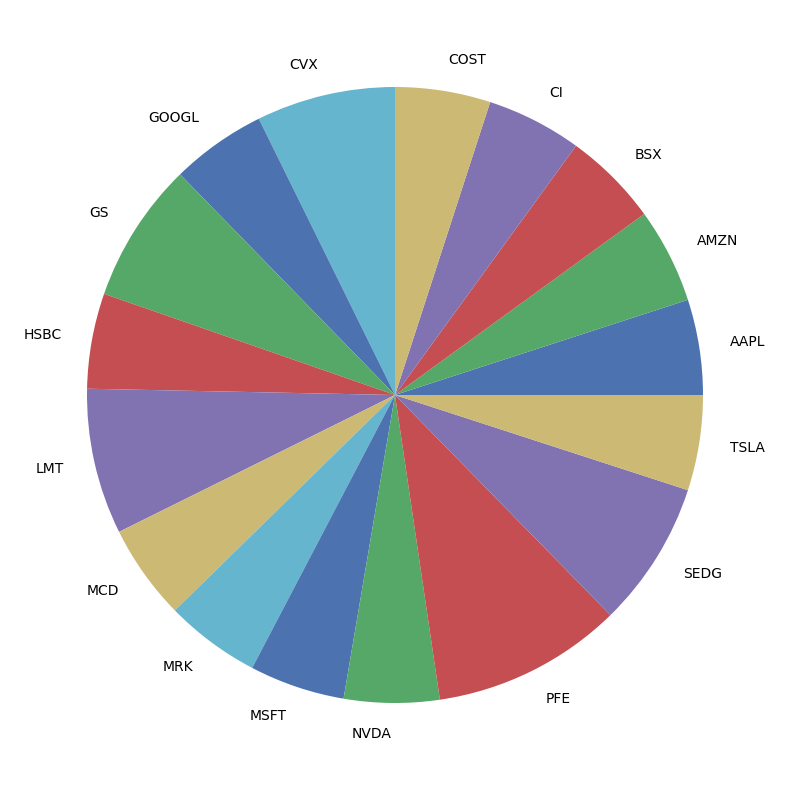

In [369]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [370]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, stock_prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $139.62


/home/tedwu/anaconda3/envs/ML_Finance/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 16,
 'BSX': 40,
 'CI': 7,
 'COST': 4,
 'CVX': 19,
 'GOOGL': 18,
 'GS': 9,
 'HSBC': 56,
 'LMT': 7,
 'MCD': 7,
 'MRK': 18,
 'MSFT': 6,
 'NVDA': 5,
 'PFE': 115,
 'SEDG': 12,
 'TSLA': 8}